/home/lab/anaconda3/envs/HSI/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Image generation time: 0.75 seconds


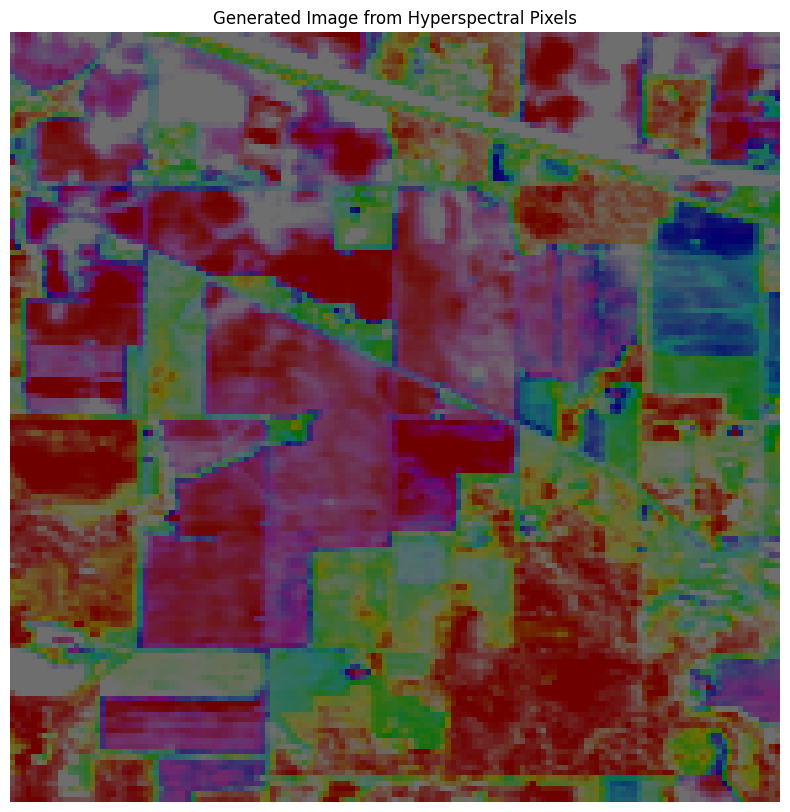

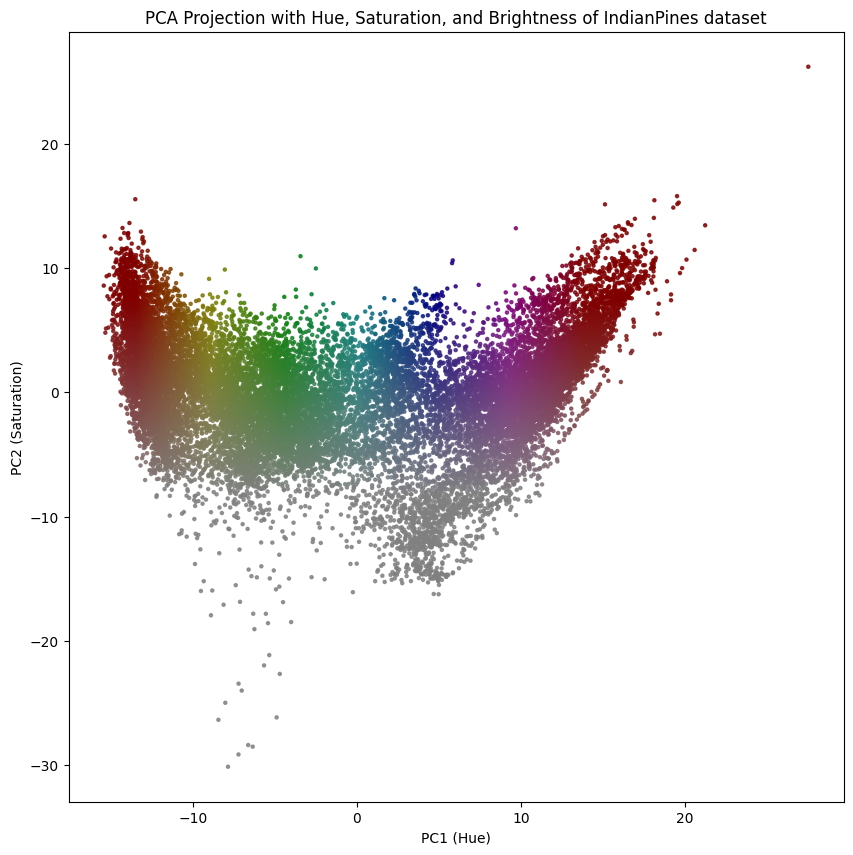

Total processing time: 1.94 seconds


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.io import loadmat
from skimage import io
import seaborn as sns
import colorsys
import time

# Start timing the process
start_time = time.time()

def calculate_entropy(image_band):
    histogram, _ = np.histogram(image_band.flatten(), bins=256, range=(0, 255), density=True)
    if histogram.sum() == 0:  # Prevent division by zero
        return 0  # Assign zero entropy for uniform bands
    histogram = histogram[histogram > 0]  # Remove zero probabilities
    entropy = -np.sum(histogram * np.log2(histogram))
    return entropy

def robust_normalization(data, lower_percentile=5, upper_percentile=95):
    """ Normalize data using percentile-based min-max scaling to avoid outliers. """
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)
    if upper == lower:  # Prevent division by zero
        return np.full_like(data, 0.5)  # Assign neutral values instead of zero
    return np.clip((data - lower) / (upper - lower), 0, 1)

def gamma_correction(image, gamma=1.2):
    """Apply gamma correction to brighten the image"""
    return np.power(image, gamma)

# Load the hyperspectral data cube from a MAT file
data = loadmat('Indian_pines_corrected.mat')
hyperspectral_cube = data['indian_pines_corrected']  # Replace 'hyperspectral_cube' with the actual variable name

# Get dimensions
rows, cols, bands = hyperspectral_cube.shape

# Compute Shannon entropy for each band
band_entropies = np.array([calculate_entropy(hyperspectral_cube[:, :, i]) for i in range(bands)])

# Normalize entropy so that the highest entropy weighted sum determines brightness
pixel_vectors = hyperspectral_cube.reshape(-1, bands)  # Flatten pixels
entropy_weighted_sum = np.dot(pixel_vectors, band_entropies)
brightness = robust_normalization(entropy_weighted_sum)
brightness = np.clip(brightness, 0, 1)  # Stretch brightness range to avoid black pixels

# Normalize each pixel spectrum (V) based on the highest pixel value per band
max_per_band = np.max(pixel_vectors, axis=0)
max_per_band[max_per_band == 0] = 1  # Prevent division by zero
norm_pixel_vectors = pixel_vectors / max_per_band  # Normalize each band to its max value

# Perform PCA (Taking pixels as samples)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(norm_pixel_vectors)

# Apply a scaling factor to increase color variation
pca_result[:, 0] *= 10  # Scale Hue
pca_result[:, 1] *= 10  # Scale Saturation

# Normalize PC1 as Hue (Outlier-proof)
hue_values = robust_normalization(pca_result[:, 0])

# Normalize PC2 as Saturation (Outlier-proof)
saturation = robust_normalization(pca_result[:, 1])

# Convert HSV to RGB properly
rgb_colors = np.array([colorsys.hsv_to_rgb(hue_values[i], saturation[i], brightness[i]) for i in range(len(hue_values))])

# Reshape RGB colors to original image dimensions
rgb_image = rgb_colors.reshape(rows, cols, 3)

# Ensure no NaN or infinite values before saving
rgb_image = np.nan_to_num(rgb_image, nan=0.0, posinf=1.0, neginf=0.0)

# Apply gamma correction
rgb_image = gamma_correction(rgb_image)

# Save the RGB image
io.imsave("CorrectedHue_Saturation_Brightness_RGB_Image.png", np.uint8(rgb_image * 255))

# End timing for image generation
image_end_time = time.time()
image_processing_time = image_end_time - start_time
print(f"Image generation time: {image_processing_time:.2f} seconds")

# Display the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("Generated Image from Hyperspectral Pixels")
plt.axis("off")
plt.show()

# Plot PCA scatter with colors
plt.figure(figsize=(10, 10))

# Scatter plot with PCA projection
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=rgb_colors, s=5, alpha=0.8)
plt.xlabel("PC1 (Hue)")
plt.ylabel("PC2 (Saturation)")
plt.title("PCA Projection with Hue, Saturation, and Brightness of IndianPines dataset")
plt.show()

# End timing the process
end_time = time.time()
processing_time = end_time - start_time
print(f"Total processing time: {processing_time:.2f} seconds")


Image generation time: 2.46 seconds


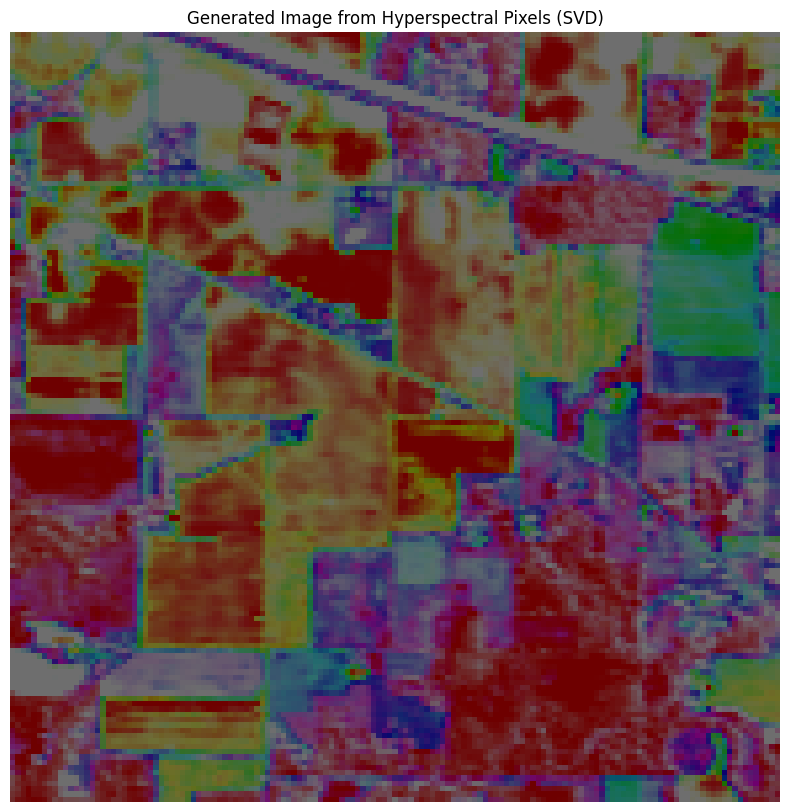

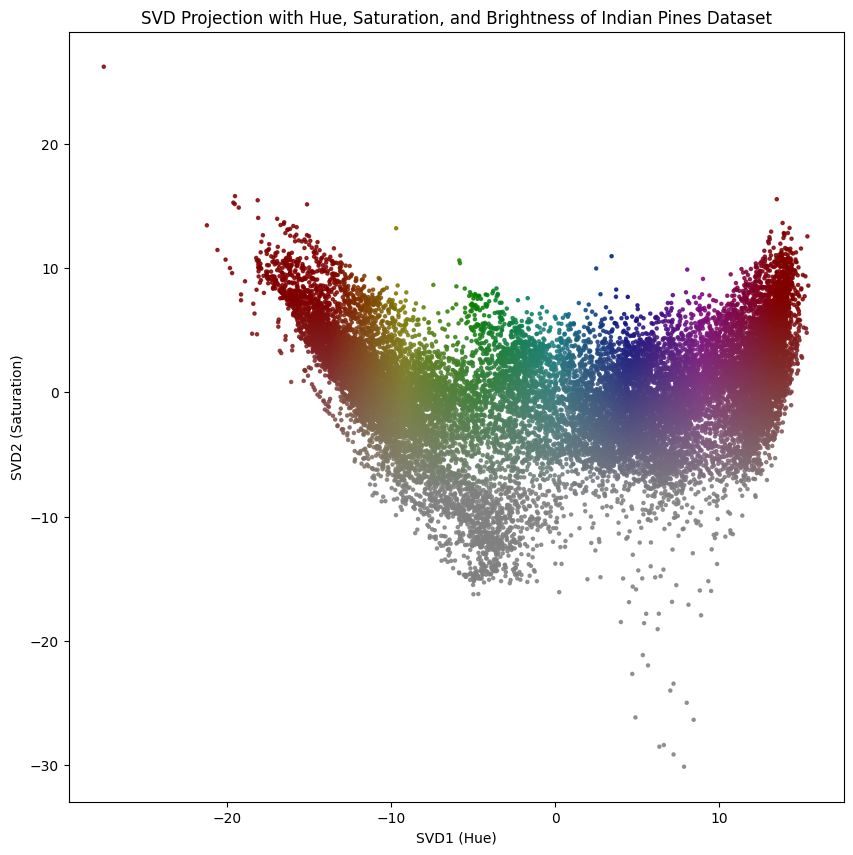

Total processing time: 3.89 seconds


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage import io
import seaborn as sns
import colorsys
import time

# Start timing the process
start_time = time.time()

def calculate_entropy(image_band):
    histogram, _ = np.histogram(image_band.flatten(), bins=256, range=(0, 255), density=True)
    if histogram.sum() == 0:  # Prevent division by zero
        return 0  # Assign zero entropy for uniform bands
    histogram = histogram[histogram > 0]  # Remove zero probabilities
    entropy = -np.sum(histogram * np.log2(histogram))
    return entropy

def robust_normalization(data, lower_percentile=5, upper_percentile=95):
    """ Normalize data using percentile-based min-max scaling to avoid outliers. """
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)
    if upper == lower:  # Prevent division by zero
        return np.full_like(data, 0.5)  # Assign neutral values instead of zero
    return np.clip((data - lower) / (upper - lower), 0, 1)

def gamma_correction(image, gamma=1.2):
    """Apply gamma correction to brighten the image"""
    return np.power(image, gamma)

# Load the hyperspectral data cube from a MAT file
data = loadmat('Indian_pines_corrected.mat')
hyperspectral_cube = data['indian_pines_corrected']

# Get dimensions
rows, cols, bands = hyperspectral_cube.shape

# Compute Shannon entropy for each band
band_entropies = np.array([calculate_entropy(hyperspectral_cube[:, :, i]) for i in range(bands)])

# Normalize entropy so that the highest entropy weighted sum determines brightness
pixel_vectors = hyperspectral_cube.reshape(-1, bands)  # Flatten pixels
entropy_weighted_sum = np.dot(pixel_vectors, band_entropies)
brightness = robust_normalization(entropy_weighted_sum)
brightness = np.clip(brightness, 0, 1)  # Stretch brightness range to avoid black pixels

# Normalize each pixel spectrum based on the highest pixel value per band
max_per_band = np.max(pixel_vectors, axis=0)
max_per_band[max_per_band == 0] = 1  # Prevent division by zero
norm_pixel_vectors = pixel_vectors / max_per_band

# Apply SVD (instead of PCA)
U, S, VT = np.linalg.svd(norm_pixel_vectors - np.mean(norm_pixel_vectors, axis=0), full_matrices=False)
svd_result = U[:, :2] * S[:2]  # Use first 2 singular vectors

# Apply a scaling factor to increase color variation
svd_result[:, 0] *= 10  # Scale Hue
svd_result[:, 1] *= 10  # Scale Saturation

# Normalize SVD1 as Hue (Outlier-proof)
hue_values = robust_normalization(svd_result[:, 0])

# Normalize SVD2 as Saturation (Outlier-proof)
saturation = robust_normalization(svd_result[:, 1])

# Convert HSV to RGB properly
rgb_colors = np.array([
    colorsys.hsv_to_rgb(hue_values[i], saturation[i], brightness[i])
    for i in range(len(hue_values))
])

# Reshape RGB colors to original image dimensions
rgb_image = rgb_colors.reshape(rows, cols, 3)

# Ensure no NaN or infinite values before saving
rgb_image = np.nan_to_num(rgb_image, nan=0.0, posinf=1.0, neginf=0.0)

# Apply gamma correction
rgb_image = gamma_correction(rgb_image)

# Save the RGB image
io.imsave("SVD_Hue_Saturation_Brightness_RGB_Image.png", np.uint8(rgb_image * 255))

# End timing for image generation
image_end_time = time.time()
image_processing_time = image_end_time - start_time
print(f"Image generation time: {image_processing_time:.2f} seconds")

# Display the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("Generated Image from Hyperspectral Pixels (SVD)")
plt.axis("off")
plt.show()

# Plot SVD scatter with colors
plt.figure(figsize=(10, 10))
plt.scatter(svd_result[:, 0], svd_result[:, 1], c=rgb_colors, s=5, alpha=0.8)
plt.xlabel("SVD1 (Hue)")
plt.ylabel("SVD2 (Saturation)")
plt.title("SVD Projection with Hue, Saturation, and Brightness of Indian Pines Dataset")
plt.show()

# End total timing
end_time = time.time()
processing_time = end_time - start_time
print(f"Total processing time: {processing_time:.2f} seconds")


Image generation time: 0.67 seconds


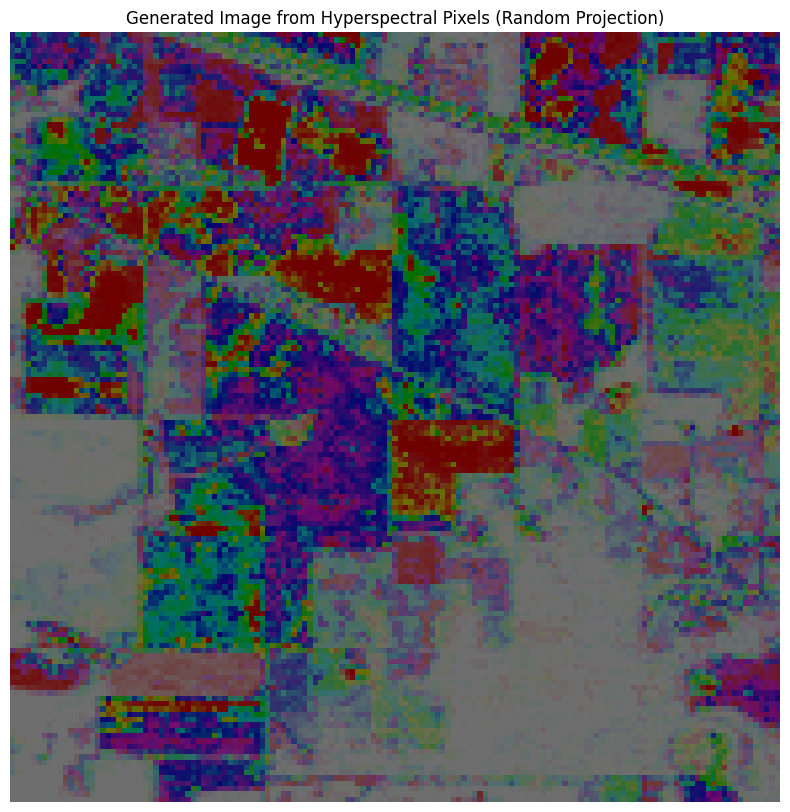

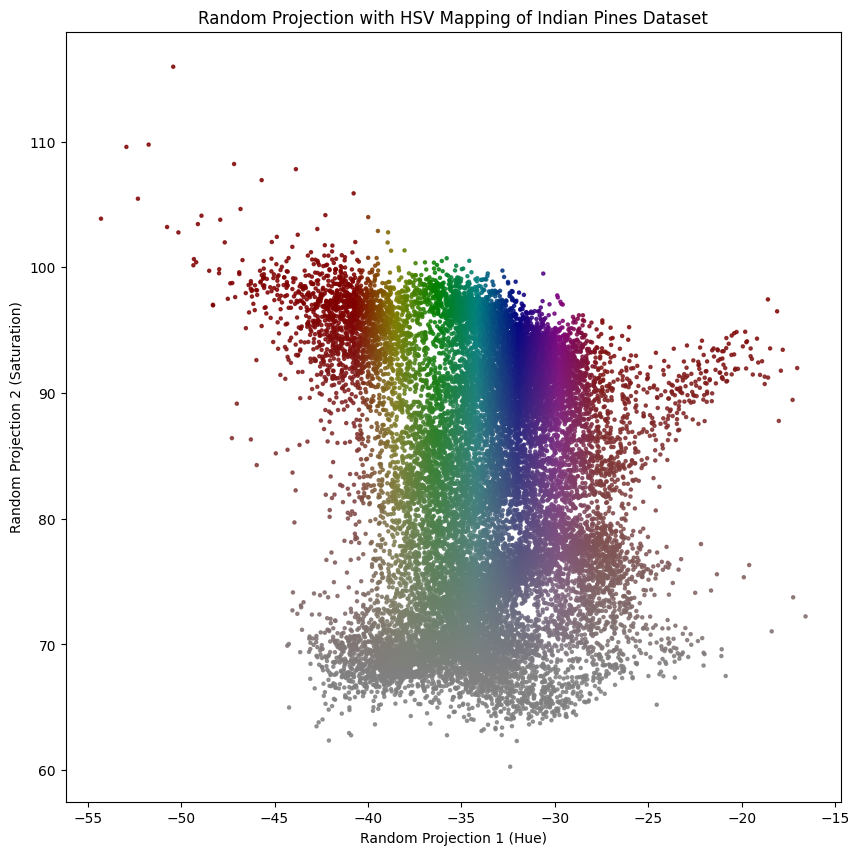

Total processing time: 4.62 seconds


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection
from scipy.io import loadmat
from skimage import io
import colorsys
import time

# Start timing the process
start_time = time.time()

def calculate_entropy(image_band):
    histogram, _ = np.histogram(image_band.flatten(), bins=256, range=(0, 255), density=True)
    if histogram.sum() == 0:
        return 0
    histogram = histogram[histogram > 0]
    entropy = -np.sum(histogram * np.log2(histogram))
    return entropy

def robust_normalization(data, lower_percentile=5, upper_percentile=95):
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)
    if upper == lower:
        return np.full_like(data, 0.5)
    return np.clip((data - lower) / (upper - lower), 0, 1)

def gamma_correction(image, gamma=1.2):
    return np.power(image, gamma)

# Load the hyperspectral data cube
data = loadmat('Indian_pines_corrected.mat')
hyperspectral_cube = data['indian_pines_corrected']

# Get dimensions
rows, cols, bands = hyperspectral_cube.shape

# Compute entropy of each band
band_entropies = np.array([calculate_entropy(hyperspectral_cube[:, :, i]) for i in range(bands)])

# Flatten pixel vectors
pixel_vectors = hyperspectral_cube.reshape(-1, bands)

# Brightness via entropy-weighted sum
entropy_weighted_sum = np.dot(pixel_vectors, band_entropies)
brightness = robust_normalization(entropy_weighted_sum)
brightness = np.clip(brightness, 0, 1)

# Normalize each pixel spectrum
max_per_band = np.max(pixel_vectors, axis=0)
max_per_band[max_per_band == 0] = 1
norm_pixel_vectors = pixel_vectors / max_per_band

# Apply Random Projection
rp = GaussianRandomProjection(n_components=2, random_state=42)
rp_result = rp.fit_transform(norm_pixel_vectors)

# Scale components to enhance visual differences
rp_result[:, 0] *= 10
rp_result[:, 1] *= 10

# Normalize to HSV space
hue_values = robust_normalization(rp_result[:, 0])
saturation = robust_normalization(rp_result[:, 1])

# Convert HSV to RGB
rgb_colors = np.array([
    colorsys.hsv_to_rgb(hue_values[i], saturation[i], brightness[i])
    for i in range(len(hue_values))
])

# Reshape to image dimensions
rgb_image = rgb_colors.reshape(rows, cols, 3)
rgb_image = np.nan_to_num(rgb_image, nan=0.0, posinf=1.0, neginf=0.0)

# Gamma correction
rgb_image = gamma_correction(rgb_image)

# Save image
io.imsave("RandomProj_Hue_Saturation_Brightness_RGB_Image.png", np.uint8(rgb_image * 255))

# Image generation time
image_end_time = time.time()
image_processing_time = image_end_time - start_time
print(f"Image generation time: {image_processing_time:.2f} seconds")

# Display image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("Generated Image from Hyperspectral Pixels (Random Projection)")
plt.axis("off")
plt.show()

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(rp_result[:, 0], rp_result[:, 1], c=rgb_colors, s=5, alpha=0.8)
plt.xlabel("Random Projection 1 (Hue)")
plt.ylabel("Random Projection 2 (Saturation)")
plt.title("Random Projection with HSV Mapping of Indian Pines Dataset")
plt.show()

# Total time
end_time = time.time()
processing_time = end_time - start_time
print(f"Total processing time: {processing_time:.2f} seconds")


/home/lab/anaconda3/envs/HSI/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Image generation time: 3.40 seconds


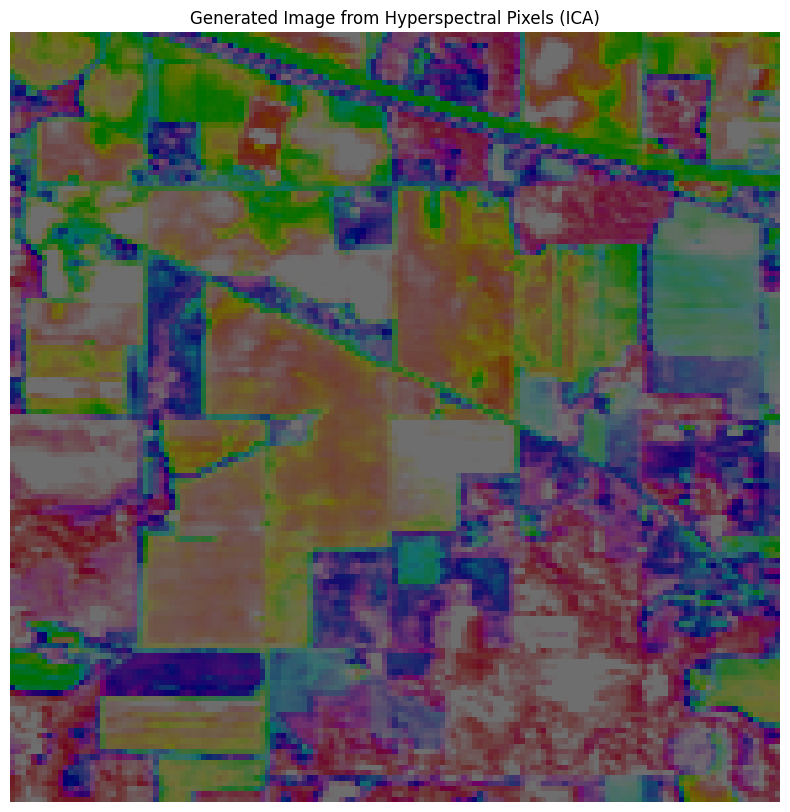

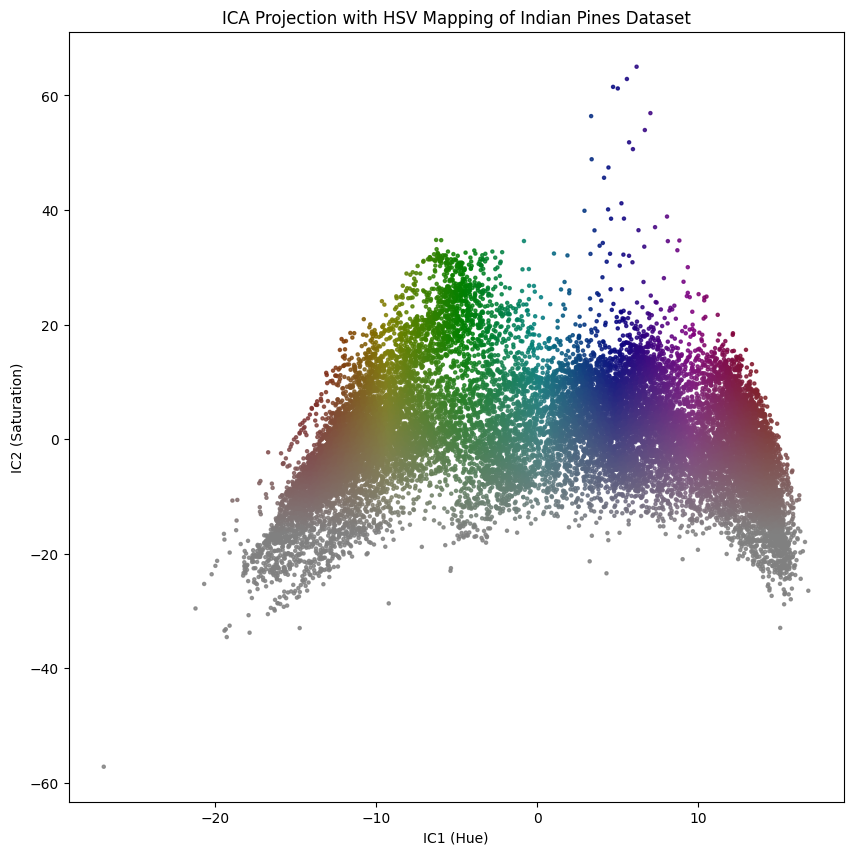

Total processing time: 4.87 seconds


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.io import loadmat
from skimage import io
import colorsys
import time

# Start timing the process
start_time = time.time()

def calculate_entropy(image_band):
    histogram, _ = np.histogram(image_band.flatten(), bins=256, range=(0, 255), density=True)
    if histogram.sum() == 0:
        return 0
    histogram = histogram[histogram > 0]
    entropy = -np.sum(histogram * np.log2(histogram))
    return entropy

def robust_normalization(data, lower_percentile=5, upper_percentile=95):
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)
    if upper == lower:
        return np.full_like(data, 0.5)
    return np.clip((data - lower) / (upper - lower), 0, 1)

def gamma_correction(image, gamma=1.2):
    return np.power(image, gamma)

# Load the hyperspectral data cube
data = loadmat('Indian_pines_corrected.mat')
hyperspectral_cube = data['indian_pines_corrected']

# Get dimensions
rows, cols, bands = hyperspectral_cube.shape

# Compute entropy of each band
band_entropies = np.array([calculate_entropy(hyperspectral_cube[:, :, i]) for i in range(bands)])

# Flatten pixel vectors
pixel_vectors = hyperspectral_cube.reshape(-1, bands)

# Brightness via entropy-weighted sum
entropy_weighted_sum = np.dot(pixel_vectors, band_entropies)
brightness = robust_normalization(entropy_weighted_sum)
brightness = np.clip(brightness, 0, 1)

# Normalize each pixel spectrum
max_per_band = np.max(pixel_vectors, axis=0)
max_per_band[max_per_band == 0] = 1
norm_pixel_vectors = pixel_vectors / max_per_band

# Apply ICA
ica = FastICA(n_components=2, random_state=42)
ica_result = ica.fit_transform(norm_pixel_vectors)

# Scale components
ica_result[:, 0] *= 10  # for Hue
ica_result[:, 1] *= 10  # for Saturation

# Normalize to HSV space
hue_values = robust_normalization(ica_result[:, 0])
saturation = robust_normalization(ica_result[:, 1])

# Convert HSV to RGB
rgb_colors = np.array([
    colorsys.hsv_to_rgb(hue_values[i], saturation[i], brightness[i])
    for i in range(len(hue_values))
])

# Reshape to image
rgb_image = rgb_colors.reshape(rows, cols, 3)
rgb_image = np.nan_to_num(rgb_image, nan=0.0, posinf=1.0, neginf=0.0)

# Gamma correction
rgb_image = gamma_correction(rgb_image)

# Save image
io.imsave("ICA_Hue_Saturation_Brightness_RGB_Image.png", np.uint8(rgb_image * 255))

# Image generation time
image_end_time = time.time()
image_processing_time = image_end_time - start_time
print(f"Image generation time: {image_processing_time:.2f} seconds")

# Show image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("Generated Image from Hyperspectral Pixels (ICA)")
plt.axis("off")
plt.show()

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(ica_result[:, 0], ica_result[:, 1], c=rgb_colors, s=5, alpha=0.8)
plt.xlabel("IC1 (Hue)")
plt.ylabel("IC2 (Saturation)")
plt.title("ICA Projection with HSV Mapping of Indian Pines Dataset")
plt.show()

# Total time
end_time = time.time()
processing_time = end_time - start_time
print(f"Total processing time: {processing_time:.2f} seconds")
